In [82]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display.display(display_animation(anim, default_mode='loop'))

In [26]:
def evaluate(env, agent, params, render, frames):
    state = env.reset()
    render_frames = []
    for e in range(frames):
        if render:
            render_frames.append(env.render(mode = 'rgb_array'))
        action = agent.act_greedy(state, e)
        state, reward, done, _ = env.step(action)
        if done or e == frames - 1:
            print("score: {}"
                  .format(e))
            break

    if render:
        env.render(close=True)
        display_frames_as_gif(render_frames)

In [32]:
def show(env, agent, params, frames):
    img = plt.imshow(env.render(mode='rgb_array'))
    state = env.reset()
    frame = 0
    for _ in range(frames):
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

        action = agent.act_greedy(state, frame)
        state, reward, done, _ = env.step(action)
        if done:
            state = env.reset()
            frame = 0
        else:
            frame += 1

In [3]:
class LearningParameters:
    def __init__(self, state_shape, action_size, episodes_count):
        self.state_shape = state_shape
        self.state_size = np.prod(state_shape)
        self.action_size = action_size
        self.episodes_count = episodes_count
        self.max_frame_in_episode = 500
        self.max_memory_size = 10000
        self.episodes_between_think = 5
        
        self.gamma = 0.95                # discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model

    def decay_exploration_rate(self, episode):
        # Linear exploration rate decay (lerp)
#         self.epsilon = self.epsilon_start - \
#                       (self.epsilon_start - self.epsilon_min) * (float(frame) / self.frames_count)
            
        # Exponential rate decay
        # y(0) = start
        # y(1) = start * x
        # y(2) = start * x^2
        # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
        # y(t) = start * x^t
        self.epsilon = self.epsilon_start * \
                       math.pow( math.pow(self.epsilon_min / self.epsilon_start, 1.0 / self.episodes_count), episode )

## Action is added to input as OHE

In [46]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        y = tf.placeholder("float", [None, 1], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([input_len, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, 1]))
        b1 = tf.Variable(tf.random_normal([1]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
        train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'train_op': train_op,
            'init': init
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']

        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(pred, {x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

TODO:
* PG magic with normalizing discounted reward
* PG magic with multiplying logprob to normalized discounted reward

In [155]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)

#         optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model)
    
        gradients = optimizer.compute_gradients(cost, var_list=tf.trainable_variables())
        train_op = optimizer.apply_gradients(gradients)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, feed_dict={x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, feed_dict={x: [state]})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(train_op, {x: X, y: Y})

## DQN Agent

In [139]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")
        
        w0 = tf.Variable(tf.random_normal([self.params.state_size, 20]))
        b0 = tf.Variable(tf.random_normal([20]))
        w1 = tf.Variable(tf.random_normal([20, self.params.action_size]))
        b1 = tf.Variable(tf.random_normal([self.params.action_size]))
        
        h0 = tf.add(tf.matmul(x, w0), b0)
        h0 = tf.nn.relu(h0)
        
        pred = tf.add(tf.matmul(h0, w1), b1)
        
        cost = tf.nn.l2_loss(pred - y)
#         train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99).minimize(cost)
        train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        return {
            'x': x,
            'y': y,
            'pred': pred,
            'cost': cost,
            'init': init,
            'train_op': train_op
        }

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        x = self.model['x']
        pred = self.model['pred']
        act_values = session.run(pred, {x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        x = self.model['x']
        y = self.model['y']
        pred = self.model['pred']
        train_op = self.model['train_op']
        cost = self.model['cost']
        
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(pred, {x: [state]})[0]
            target[action] = reward + self.params.gamma * \
                             np.amax(session.run(pred, {x: [next_state]})[0])
            X[i], Y[i] = state, target

        for e in range(1):
            P = np.random.permutation(cnt)
            for i in range(0, cnt, batch_size):
                batch_indexes = P[i: i + batch_size]
                batch_x = X[batch_indexes]
                batch_y = Y[batch_indexes]
                _ = session.run(train_op, {x: batch_x, y: batch_y})

In [6]:
# print(env.spec.max_episode_steps)
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Breakout-v0')
# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-07-16 10:59:33,578] Making new env: CartPole-v1


Actions: 2, Observation space (4,), 4 parameters


In [ ]:
params = LearningParameters(env.observation_space.shape, env.action_space.n, 500)

params.episodes_between_think = 1
agent = PolicyGradientAgent(params)

# agent = DqnAgent(params)

# agent = ActionAsInputAgent(params)

if 'session' in locals():
    session.close()
session = tf.Session()
session.run(agent.model['init'])

agent, rewards = train_discounted_rewards(env, agent, params)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

episode: 25/500, reward 23.4, exploration rate: 0.65
episode: 50/500, reward 29.0, exploration rate: 0.41
episode: 75/500, reward 72.4, exploration rate: 0.26
episode: 100/500, reward 85.2, exploration rate: 0.16
episode: 125/500, reward 113.4, exploration rate: 0.1
episode: 150/500, reward 109.7, exploration rate: 0.065
episode: 175/500, reward 98.0, exploration rate: 0.041
episode: 200/500, reward 151.9, exploration rate: 0.026
episode: 225/500, reward 199.6, exploration rate: 0.016
episode: 250/500, reward 164.4, exploration rate: 0.01
episode: 275/500, reward 136.9, exploration rate: 0.0065
episode: 300/500, reward 143.7, exploration rate: 0.0041
episode: 325/500, reward 135.8, exploration rate: 0.0026
episode: 350/500, reward 122.1, exploration rate: 0.0016
episode: 375/500, reward 135.6, exploration rate: 0.001
episode: 400/500, reward 148.0, exploration rate: 0.00065
episode: 425/500, reward 134.0, exploration rate: 0.00041
episode: 450/500, reward 144.4, exploration rate: 0.000

In [135]:
evaluate(env, agent, params, False, 500)

score: 499


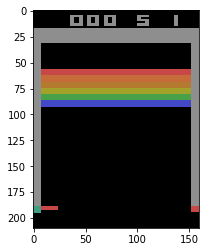

In [52]:
show(env, agent, params, 100)